# TP1 - Parte B: Classificação de Atividades Humanas 
### Tópicos de Ciência dos Dados - MECD (2022/2023)

### Autores

- Duarte Meneses - 2019216949
- Patricia Costa - 2019213995


In [129]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd

## 4.5 e 4.6 da Parte A

### 4.5. ReliefF

In [130]:
from ReliefF import ReliefF

def reliefF(x, y):
    fs = ReliefF(n_features_to_keep=10)
    fs.fit_transform(x, y)

    return fs.top_features[:10]

### 4.6. Fisher Score

In [131]:
from skfeature.function.similarity_based import fisher_score

def fisherScore(x, y):
    return fisher_score.fisher_score(x, y)

## Parte B


### 1.1. Data Splitting

### 1.1.1. Train-Test (TT) e Train-Validation-Test data split

In [132]:
from sklearn.model_selection import train_test_split
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

def train_test(data, target, train_size):

    x_train, x_test, y_train, y_test = train_test_split(data, target, train_size=train_size)

    trainTest = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]}

    return trainTest

def train_validation_test(data, target, train_size, test_size):

    x_train, x_rem, y_train, y_rem = train_test_split(data, target, train_size=train_size)

    # 1 - train_size -> correponde agora ao nosso 100%(1)
    # test_size -> test_size / (1-train_size)

    test = test_size / (1-train_size)

    x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size = test)

    trainValidation = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test], "VALIDATION": [x_valid, y_valid]}
    
    return trainValidation



### 1.1.2. K-fold data split

In [133]:
from sklearn.model_selection import KFold
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

def k_fold(x, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle = True)
    kfold = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        kfold.append({"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]})
    
    return kfold

In [134]:
#Testes
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

print("--Train Test--\n")
trainTest = train_test(X, y, 0.7)
display(trainTest)

print("\n--Train Validation Test--\n")
trainValidation = train_validation_test(X, y, 0.4, 0.3)
display(trainValidation)

print("\n--K Fold--\n")
kFold = k_fold(X, y, 4)
display(kFold)

--Train Test--



{'TRAIN': [array([[3, 4],
         [3, 4]]),
  array([2, 4])],
 'TEST': [array([[1, 2],
         [1, 2]]),
  array([1, 3])]}


--Train Validation Test--



{'TRAIN': [array([[1, 2]]), array([1])],
 'TEST': [array([[1, 2],
         [3, 4]]), array([3, 2])],
 'VALIDATION': [array([[3, 4]]), array([4])]}


--K Fold--



[{'TRAIN': [array([[1, 2],
          [3, 4],
          [1, 2]]),
   array([1, 2, 3])],
  'TEST': [array([[3, 4]]), array([4])]},
 {'TRAIN': [array([[1, 2],
          [1, 2],
          [3, 4]]),
   array([1, 3, 4])],
  'TEST': [array([[3, 4]]), array([2])]},
 {'TRAIN': [array([[3, 4],
          [1, 2],
          [3, 4]]),
   array([2, 3, 4])],
  'TEST': [array([[1, 2]]), array([1])]},
 {'TRAIN': [array([[1, 2],
          [3, 4],
          [3, 4]]),
   array([1, 2, 4])],
  'TEST': [array([[1, 2]]), array([3])]}]

### 1.2. Métricas de exactidação

In [135]:
#Teste
true = [2, 0, 2, 2, 0, 1]
pred = [0, 0, 2, 2, 0, 2]

-> Explicação do parâmetro average

**'binary'**:
Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.

**'micro'**:
Calculate metrics globally by counting the total true positives, false negatives and false positives.

**'macro'**:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

**'weighted'**:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

**'samples'**:
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

,Metrics
Recall,0.666667
Precision,0.555556
F1-score,0.600000


,0,1,2
0,2,0,0
1,0,0,1
2,1,0,2


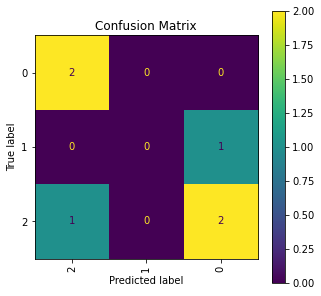

In [205]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import recall_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
from sklearn.metrics import precision_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
from sklearn.metrics import f1_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

def metrics(true, pred, printar = False):

    with open('true.txt', 'w') as f:
        for line in true:
            f.write("%s / " % line)
    with open('pred.txt', 'w') as f:
        for line in pred:
            f.write("%s / " % line)

    cm = confusion_matrix(true, pred)
    rs = recall_score(true, pred, average='weighted', zero_division=0)
    ps = precision_score(true, pred, average='weighted', zero_division=0)
    f1 = f1_score(true, pred, average='weighted', zero_division=0)

    if(printar):
        print('Confusion Matrix:\n', cm)
        print('\nRecall: ', rs)
        print('\nPrecision: ', ps)
        print('\nF1-score: ', f1)
        print('-'*50)

    return [cm, rs, ps, f1]

def mais_bonito(cm, rs, ps, f1, labels):

    metricsFrame = pd.DataFrame([rs, ps, f1], columns=['Metrics']).rename(index={0: 'Recall', 1: 'Precision', 2: 'F1-score'})
    display(metricsFrame)

    try:
        cmFrame = pd.DataFrame(cm, columns=labels, index=labels).style.set_caption("Confusion Matrix")
        display(cmFrame)

        cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
        _, ax = plt.subplots(figsize=(5,5))
        cmp.plot(ax=ax)
        ax.set_title("Confusion Matrix")
        ax.xaxis.set_ticklabels(labels)
        ax.xaxis.set_ticklabels(labels[::-1], rotation=90)
        plt.show()

    except:
        cmFrame = pd.DataFrame(cm).style.set_caption("Confusion Matrix")
        display(cmFrame)

cm, rs, ps, f1 = metrics(true, pred)
mais_bonito(cm, rs, ps, f1, [0,1,2])



### 2.1. Dataset

In [137]:
iris = datasets.load_iris()

data = iris.data
target = iris.target

display(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

### 2.1. k-Nearest Neighbours

In [138]:
from sklearn.neighbors import KNeighborsClassifier

def K_neighbors_classifier(x, y, k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x, y)

    return neigh


### 2.1.1. Train-only

,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


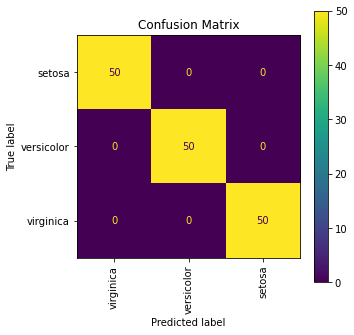

In [139]:
def TO_211(x, y, labels, k):
    neigh = K_neighbors_classifier(x, y, k)
    pred = neigh.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TO_211(data, target, iris["target_names"], 1)

### 2.1.1. TT 70-30

,Metrics
Recall,0.955556
Precision,0.955556
F1-score,0.955556


,setosa,versicolor,virginica
setosa,13,0,0
versicolor,0,17,1
virginica,0,1,13


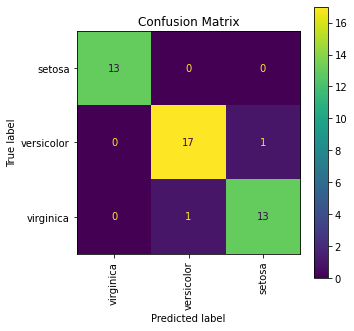

In [140]:
def TT_211(x, y, labels, k):
    trainTest = train_test(x, y, 0.7)
    neigh = K_neighbors_classifier(trainTest['TRAIN'][0], trainTest['TRAIN'][1], k)
    pred = neigh.predict(trainTest['TEST'][0])
    true = trainTest['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TT_211(data, target, iris["target_names"], 1)

### 2.1.1. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,6,0
virginica,0,0,4


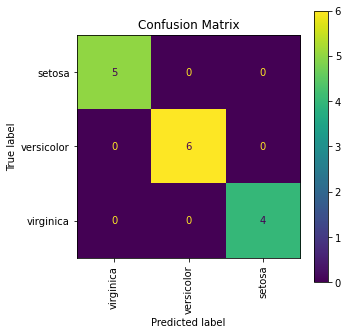

------------------- Iteração 1 -------------------


,Metrics
Recall,0.933333
Precision,0.942857
F1-score,0.932867


,setosa,versicolor,virginica
setosa,3,0,0
versicolor,0,6,0
virginica,0,1,5


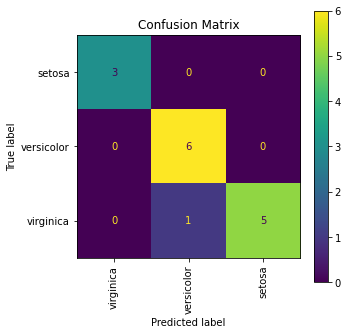

------------------- Iteração 2 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,7,0
virginica,0,0,4


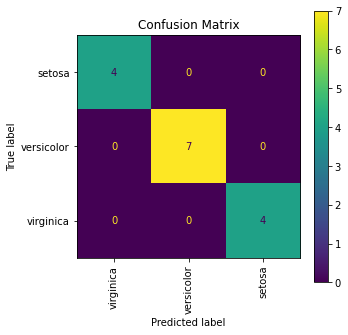

------------------- Iteração 3 -------------------


,Metrics
Recall,0.933333
Precision,0.955556
F1-score,0.936296


,setosa,versicolor,virginica
setosa,8,0,0
versicolor,0,4,1
virginica,0,0,2


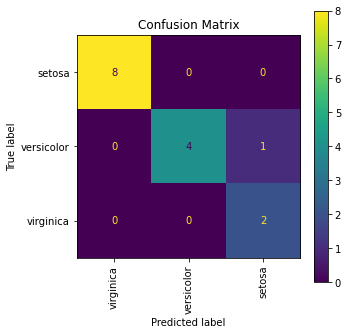

------------------- Iteração 4 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,4,0
virginica,0,0,7


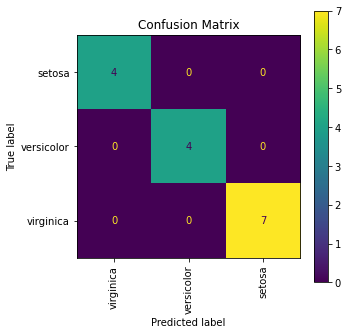

------------------- Iteração 5 -------------------


,Metrics
Recall,0.933333
Precision,0.955556
F1-score,0.937778


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,7,1
virginica,0,0,2


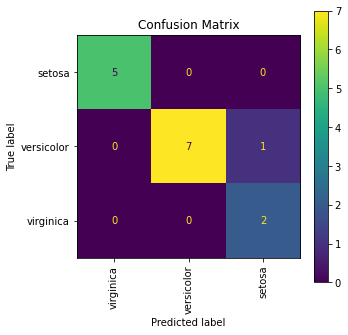

------------------- Iteração 6 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,8,0,0
versicolor,0,2,0
virginica,0,0,5


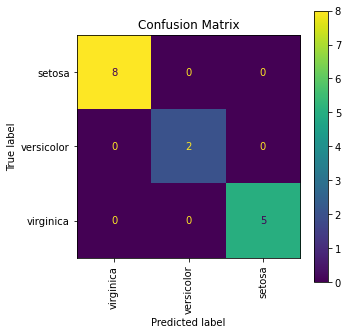

------------------- Iteração 7 -------------------


,Metrics
Recall,0.800000
Precision,0.802381
F1-score,0.796581


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,5,1
virginica,0,2,3


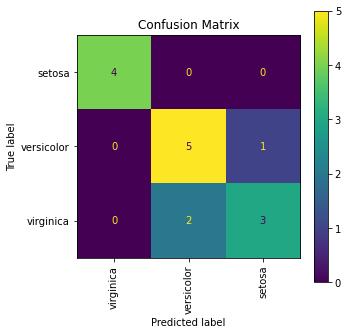

------------------- Iteração 8 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,4,0
virginica,0,0,6


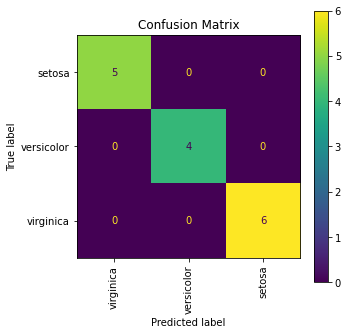

------------------- Iteração 9 -------------------


,Metrics
Recall,0.933333
Precision,0.955556
F1-score,0.938039


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,2,0
virginica,0,1,8


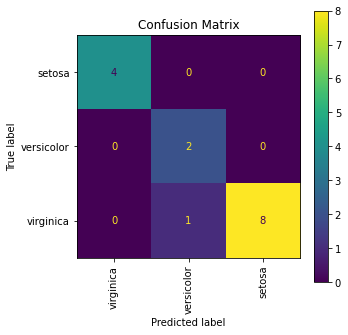

In [141]:
def CV_211(x, y, n_splits, labels, k):
    kf = k_fold(x, y, n_splits)

    count = 0
    for info in kf:
        print("------------------- Iteração " + str(count) + " -------------------")

        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]

        cm, rs, ps, f1 = metrics(true, pred)

        mais_bonito(cm, rs, ps, f1, labels)

        count += 1

CV_211(data, target, 10, iris["target_names"], 1)

### 2.1.2. k na gama {1, 3, 5, ...,15}

In [142]:
_k = np.arange(1, 16, 2)

display(_k)

array([ 1,  3,  5,  7,  9, 11, 13, 15])

### 2.1.2. Train-only

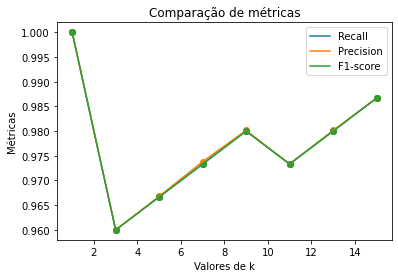

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


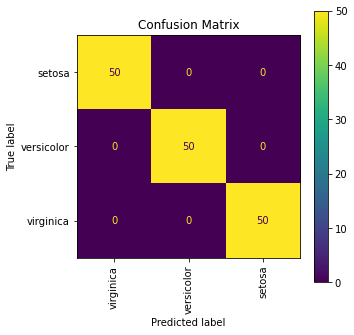

In [143]:
def TO_212(x, y, metr):
    for k in _k:
        neigh = K_neighbors_classifier(x, y, k)
        pred = neigh.predict(x)
        true = y
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)

    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def TO_gama(x, y, labels):
    metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
    
    new_metr = TO_212(x, y, metr)

    plot_metricas(new_metr)

    pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
    best_k = _k[pos_k]
    print("Best K: " + str(best_k))

    neigh = K_neighbors_classifier(x, y, best_k)
    pred = neigh.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)

    mais_bonito(cm, rs, ps, f1, labels)

TO_gama(data, target, iris["target_names"])

### 2.1.2. TVT 40-30-30

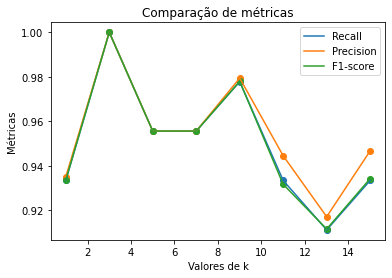

Best K: 3


,Metrics
Recall,0.933333
Precision,0.934907
F1-score,0.933473


,setosa,versicolor,virginica
setosa,14,0,0
versicolor,0,13,1
virginica,0,2,15


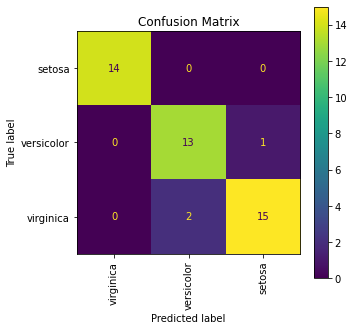

In [144]:
# TODO
# VER O MELHOR K -> FEITO
# PARA O MELHOR K, TESTAR COM O TREINO + VALIDATION JUNTOS, USANDO O TEST COMO PRED


def TVT_212(x, y, metr):
    for k in _k:
        trainValidation = train_validation_test(x, y, 0.4, 0.3)

        neigh = K_neighbors_classifier(trainValidation['TRAIN'][0], trainValidation['TRAIN'][1], k)
        pred = neigh.predict(trainValidation['VALIDATION'][0])
        true = trainValidation['VALIDATION'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)
    
    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def TVT_gama(x, y, labels):
    metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
    
    new_metr = TVT_212(x, y, metr)

    plot_metricas(new_metr)

    pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
    best_k = _k[pos_k]
    print("Best K: " + str(best_k))

    trainValidation = train_validation_test(x, y, 0.4, 0.3)

    newTrain0 = np.concatenate((trainValidation['TRAIN'][0], trainValidation['VALIDATION'][0]), axis=0)
    newTrain1 = np.concatenate((trainValidation['TRAIN'][1], trainValidation['VALIDATION'][1]), axis=0)

    neigh = K_neighbors_classifier(newTrain0, newTrain1, best_k)
    pred = neigh.predict(trainValidation['TEST'][0])
    true = trainValidation['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)

    mais_bonito(cm, rs, ps, f1, labels)

TVT_gama(data, target, iris["target_names"])

### 2.1.2. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


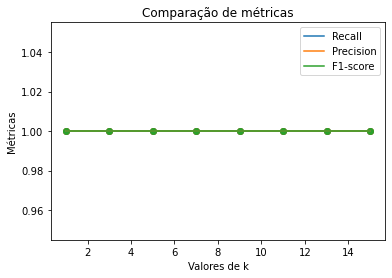

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,7,0,0
versicolor,0,4,0
virginica,0,0,4


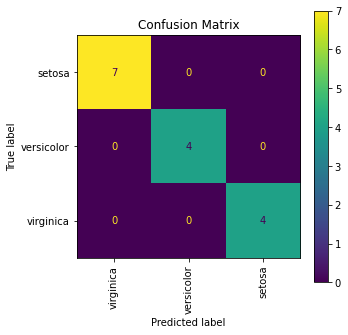

------------------- Iteração 1 -------------------


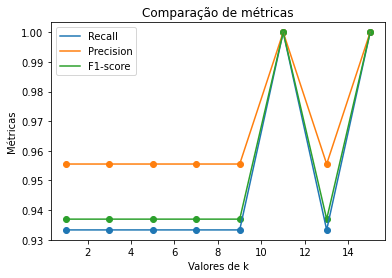

Best K: 11


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,7,0,0
versicolor,0,6,0
virginica,0,0,2


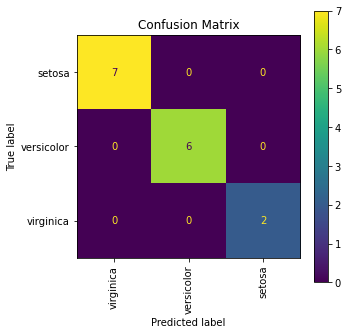

------------------- Iteração 2 -------------------


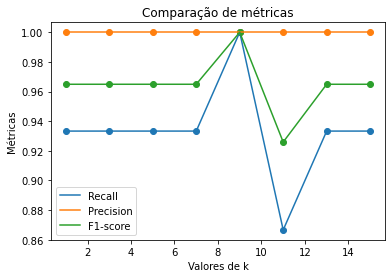

Best K: 9


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,0,1
0,5,0
1,0,10


------------------- Iteração 3 -------------------


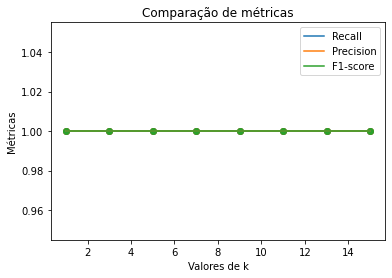

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,5,0
virginica,0,0,6


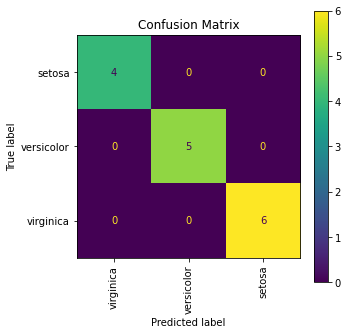

------------------- Iteração 4 -------------------


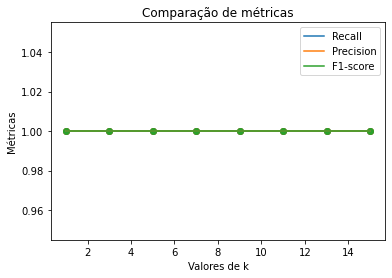

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,3,0
virginica,0,0,6


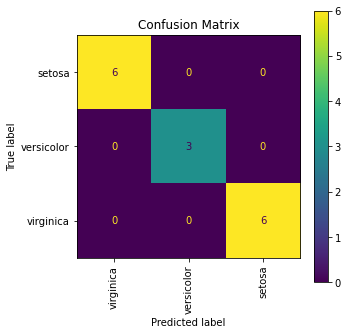

------------------- Iteração 5 -------------------


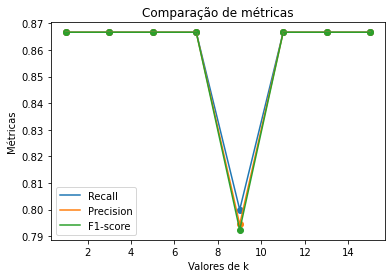

Best K: 1


,Metrics
Recall,0.866667
Precision,0.866667
F1-score,0.866667


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,6,1
virginica,0,1,3


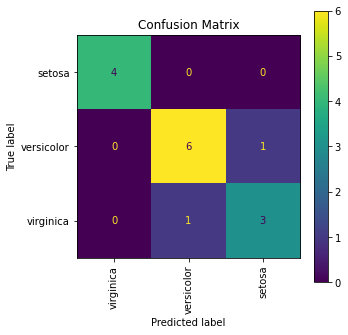

------------------- Iteração 6 -------------------


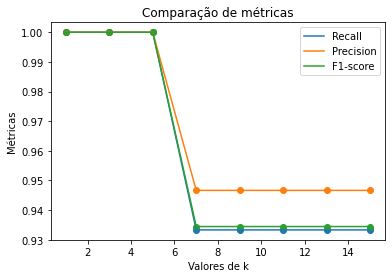

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,7,0
virginica,0,0,4


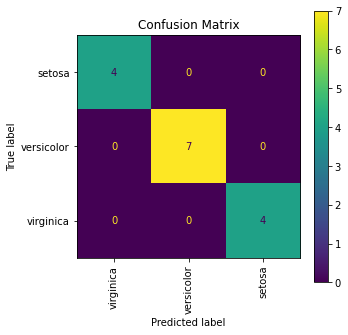

------------------- Iteração 7 -------------------


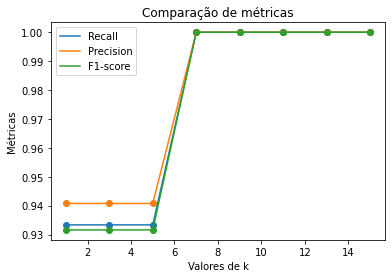

Best K: 7


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,2,0,0
versicolor,0,8,0
virginica,0,0,5


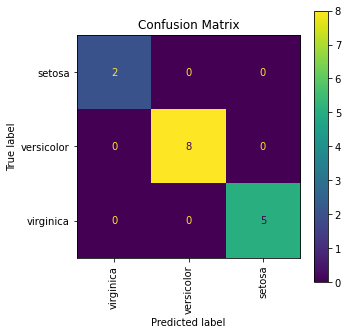

------------------- Iteração 8 -------------------


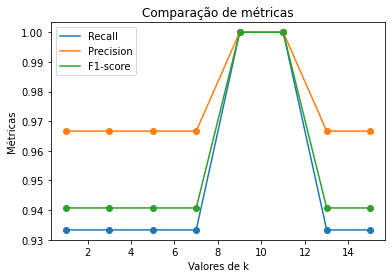

Best K: 9


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,9,0,0
versicolor,0,5,0
virginica,0,0,1


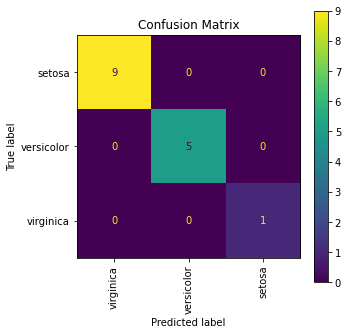

------------------- Iteração 9 -------------------


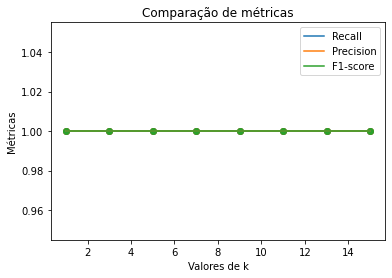

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,2,0,0
versicolor,0,5,0
virginica,0,0,8


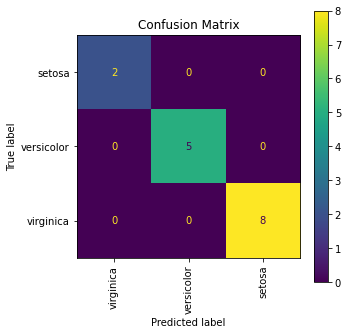

In [145]:
def CV_212(info, metr):
    for k in _k:
        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)

    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def CV_gama(x, y, labels):
    
    kf = k_fold(x, y, 10)
    count = 0
    for info in kf:
        metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
        print("------------------- Iteração " + str(count) + " -------------------")
        count += 1
        new_metr = CV_212(info, metr)

        plot_metricas(new_metr)

        pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
        best_k = _k[pos_k]
        print("Best K: " + str(best_k))

        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], best_k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        mais_bonito(cm, rs, ps, f1, labels)

CV_gama(data, target, iris["target_names"])

### 2.1.3. Bias-Variance e Underfitting-Overfitting

![image desc](./Part_B/image/Bias_Variance.jpeg)

'[image' is not recognized as an internal or external command,
operable program or batch file.


### 2.2. ReliefF

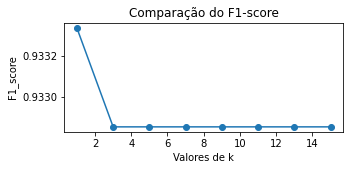

Nr of features: 1
Best K: 1
F1_score: 0.9330511463844797
--------------------------------------------------


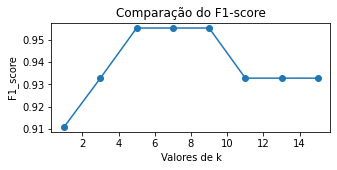

Nr of features: 2
Best K: 5
F1_score: 0.9776837154614932
--------------------------------------------------


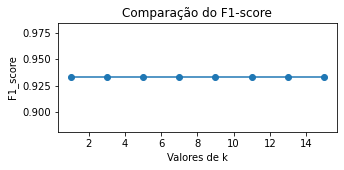

Nr of features: 3
Best K: 1
F1_score: 0.9555555555555556
--------------------------------------------------


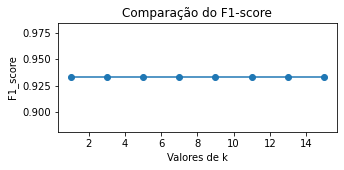

Nr of features: 4
Best K: 1
F1_score: 0.9555555555555556
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.933333,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855
Nº of features: 2,0.910899,0.932855,0.955450,0.955450,0.955450,0.932855,0.932855,0.932855
Nº of features: 3,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855
Nº of features: 4,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855


In [146]:
def plot_f1(metr_f1):
    plt.figure(figsize=(5,2))

    plt.plot(_k, metr_f1["F1-score"])
    plt.scatter(_k, metr_f1["F1-score"])
    
    plt.title("Comparação do F1-score")
    plt.xlabel("Valores de k")
    plt.ylabel("F1_score")
    plt.show()

def bestkTVT(metr, feat, xTrain, xValidation, trainValidation, s):
    s += 'Nr of features: ' + str(len(feat)) + '\n'
    print('Nr of features: ' + str(len(feat)))
    pos_k = metr["F1-score"].index(max(metr["F1-score"]))
    best_k = _k[pos_k]
    s += "Best K: " + str(best_k) + '\n'
    print("Best K: " + str(best_k))

    newTrain0 = np.concatenate((xTrain, xValidation), axis=0)
    newTrain1 = np.concatenate((trainValidation['TRAIN'][1], trainValidation['VALIDATION'][1]), axis=0)

    neigh = K_neighbors_classifier(newTrain0, newTrain1, best_k)
    xTest = trainValidation['TEST'][0][:,feat]
    pred = neigh.predict(xTest)
    true = trainValidation['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)

    s += 'F1_score: ' + str(f1) + '\n' + '-'*50 + '\n'
    print('F1_score: ' + str(f1))
    print('-'*50)

    return f1, s

def repeatTVT(x, y, featselec, num = 4):

    trainValidation = train_validation_test(x, y, 0.4, 0.3)

    f1_score = []
    f1_score_elbow = []
    str_print = ''

    for f in range(num):
        metr = {"F1-score": []}
        feat = featselec[:(f+1)]
        xTrain = trainValidation['TRAIN'][0][:,feat]
        xValidation = trainValidation['VALIDATION'][0][:,feat]

        for k in _k:
            neigh = K_neighbors_classifier(xTrain, trainValidation['TRAIN'][1], k)
            pred = neigh.predict(xValidation)
            true = trainValidation['VALIDATION'][1]
            cm, rs, ps, f1 = metrics(true, pred)

            metr["F1-score"].append(f1)
        f1_score.append(metr["F1-score"])

        #------------Plot F1-Score--------------------------
        plot_f1(metr)

        #------------Best k--------------------------
        aux, str_print = bestkTVT(metr, feat, xTrain, xValidation, trainValidation, str_print)
        f1_score_elbow.append(aux)

    label = ['Nº of features: ' + str(i+1) for i in range(len(featselec))]
    col = ['k=' + str(i) for i in _k]
    df = pd.DataFrame(f1_score, columns = col, index = label)
    display(df)

    return f1_score_elbow, df, str_print
        

f1_score_elbow, df223, str_print = repeatTVT(data, target, reliefF(data, target))

### 2.2.2 Elbow graph

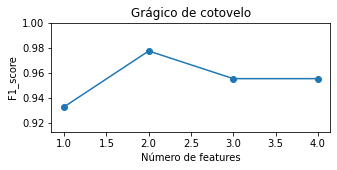

In [147]:
def elbowGraph(lista_f1, num):
    index = np.arange(1,num)

    plt.figure(figsize=(5,2))
    plt.ylim(min(lista_f1)-0.02,1)

    plt.plot(index, lista_f1)
    plt.scatter(index, lista_f1)
    
    plt.title("Grágico de cotovelo")
    plt.xlabel("Número de features")
    plt.ylabel("F1_score")
    plt.show()

elbowGraph(f1_score_elbow, 5)

### 2.2.3. Validation set results

In [148]:
display(df223)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.933333,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855
Nº of features: 2,0.910899,0.932855,0.955450,0.955450,0.955450,0.932855,0.932855,0.932855
Nº of features: 3,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855
Nº of features: 4,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855,0.932855


### 2.2.4. Test set results

In [149]:
print(str_print)

Nr of features: 1
Best K: 1
F1_score: 0.9330511463844797
--------------------------------------------------
Nr of features: 2
Best K: 5
F1_score: 0.9776837154614932
--------------------------------------------------
Nr of features: 3
Best K: 1
F1_score: 0.9555555555555556
--------------------------------------------------
Nr of features: 4
Best K: 1
F1_score: 0.9555555555555556
--------------------------------------------------



### 2.3. Fisher Score

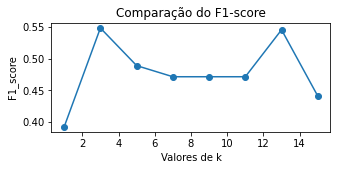

Nr of features: 1
Best K: 3
F1_score: 0.5538945005611673
--------------------------------------------------


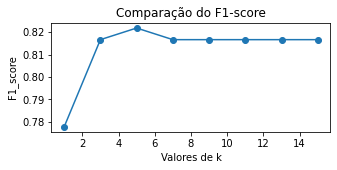

Nr of features: 2
Best K: 5
F1_score: 0.8217989417989418
--------------------------------------------------


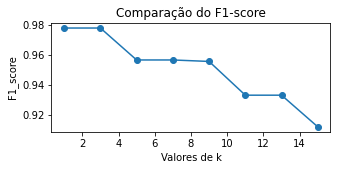

Nr of features: 3
Best K: 1
F1_score: 0.9555555555555556
--------------------------------------------------


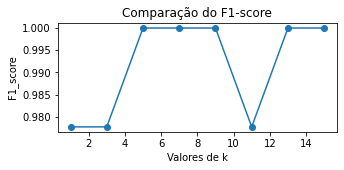

Nr of features: 4
Best K: 5
F1_score: 0.9555555555555556
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.392692,0.548186,0.489041,0.471538,0.471538,0.471538,0.545419,0.441125
Nº of features: 2,0.777737,0.816704,0.821902,0.816704,0.816704,0.816704,0.816704,0.816704
Nº of features: 3,0.977778,0.977778,0.956536,0.956536,0.955556,0.933119,0.933119,0.912061
Nº of features: 4,0.977778,0.977778,1.000000,1.000000,1.000000,0.977778,1.000000,1.000000


In [150]:
score = fisherScore(data, target)

f1_score_elbow, df223, str_print = repeatTVT(data, target, score)


### 2.3.2. Elbow Graph

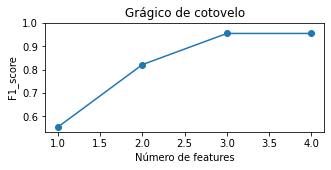

In [151]:
elbowGraph(f1_score_elbow, 5)

### 2.3.3. Validation set results

In [152]:
display(df223)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.392692,0.548186,0.489041,0.471538,0.471538,0.471538,0.545419,0.441125
Nº of features: 2,0.777737,0.816704,0.821902,0.816704,0.816704,0.816704,0.816704,0.816704
Nº of features: 3,0.977778,0.977778,0.956536,0.956536,0.955556,0.933119,0.933119,0.912061
Nº of features: 4,0.977778,0.977778,1.000000,1.000000,1.000000,0.977778,1.000000,1.000000


### 2.3.4. Test set results

In [153]:
print(str_print)

Nr of features: 1
Best K: 3
F1_score: 0.5538945005611673
--------------------------------------------------
Nr of features: 2
Best K: 5
F1_score: 0.8217989417989418
--------------------------------------------------
Nr of features: 3
Best K: 1
F1_score: 0.9555555555555556
--------------------------------------------------
Nr of features: 4
Best K: 5
F1_score: 0.9555555555555556
--------------------------------------------------



### 2.4. Class imbalance

 'target_names': array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [154]:
irisDF = pd.DataFrame(iris.data, columns=iris["feature_names"])
irisDF["target"] = iris["target"]
setosa = irisDF[irisDF["target"] == 0]
versicolor = irisDF[irisDF["target"] == 1].sample(30)
virginica = irisDF[irisDF["target"] == 2].sample(10)
new_iris = pd.concat([setosa, versicolor, virginica], axis=0)
new_iris.groupby("target").count()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
0,50,50,50,50
1,30,30,30,30
2,10,10,10,10


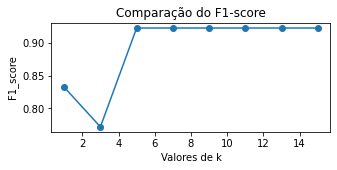

Nr of features: 1
Best K: 5
F1_score: 0.4357298474945534
--------------------------------------------------


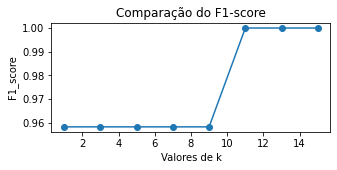

Nr of features: 2
Best K: 11
F1_score: 0.7407407407407407
--------------------------------------------------


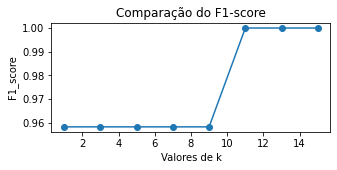

Nr of features: 3
Best K: 11
F1_score: 0.7407407407407407
--------------------------------------------------


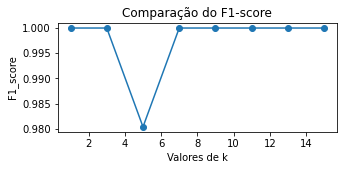

Nr of features: 4
Best K: 1
F1_score: 0.92003367003367
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.832579,0.771795,0.923246,0.923246,0.923246,0.923246,0.923246,0.923246
Nº of features: 2,0.958333,0.958333,0.958333,0.958333,0.958333,1.000000,1.000000,1.000000
Nº of features: 3,0.958333,0.958333,0.958333,0.958333,0.958333,1.000000,1.000000,1.000000
Nº of features: 4,1.000000,1.000000,0.980392,1.000000,1.000000,1.000000,1.000000,1.000000


In [155]:
aux_data = np.array(new_iris.drop(columns=["target"]))
aux_target = np.array(new_iris["target"])

score = fisherScore(aux_data, aux_target)

newIris_elbow, df224, str_print = repeatTVT(aux_data, aux_target, score)

### 2.4.2. Elbow Graph

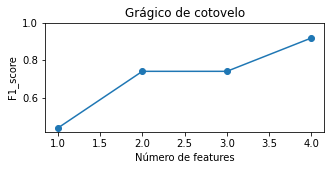

In [156]:
elbowGraph(newIris_elbow, 5)

### 2.4.3. Validation set results

In [157]:
display(df224)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.832579,0.771795,0.923246,0.923246,0.923246,0.923246,0.923246,0.923246
Nº of features: 2,0.958333,0.958333,0.958333,0.958333,0.958333,1.000000,1.000000,1.000000
Nº of features: 3,0.958333,0.958333,0.958333,0.958333,0.958333,1.000000,1.000000,1.000000
Nº of features: 4,1.000000,1.000000,0.980392,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.4.4. Test set results

In [158]:
print(str_print)

Nr of features: 1
Best K: 5
F1_score: 0.4357298474945534
--------------------------------------------------
Nr of features: 2
Best K: 11
F1_score: 0.7407407407407407
--------------------------------------------------
Nr of features: 3
Best K: 11
F1_score: 0.7407407407407407
--------------------------------------------------
Nr of features: 4
Best K: 1
F1_score: 0.92003367003367
--------------------------------------------------



### 3. ReliefF for dataset of human activity

In [159]:
activities = np.array(['Stand', 'Sit', 'Sit and Talk', 'Walk', 'Walk and Talk', 'Climb Stair (up/down)',
    'Climb Stair (up/down) and talk', 'Stand -> Sit', 'Sit -> Stand', 'Stand -> Sit and talk', 'Sit -> Stand and talk',
    'Stand -> walk', 'Walk -> stand', 'Stand -> climb stairs (up/down)(and talk)', 'Climb stairs (up/down) -> walk',
    'Climb stairs (up/down) and talk -> walk and talk'])
    
Acc_features = pd.read_csv("dataset/Acc_features.csv").drop(columns='Unnamed: 0')
Gyr_features = pd.read_csv("dataset/Gyr_features.csv").drop(columns=['Unnamed: 0','Label'])
Mag_features = pd.read_csv("dataset/Mag_features.csv").drop(columns=['Unnamed: 0', 'Label'])

new_data = pd.concat([Acc_features, Gyr_features, Mag_features], axis=1)
new_data.to_csv('features.csv', encoding='utf-8')
display(new_data)

new_target = np.array(new_data["Label"])
feature_data = np.array(new_data.drop(columns = ["Label"]))

,Label,Acc X Mean,Acc X Median,Acc X Std,Acc X Variance,Acc X RMS,Acc X AD,Acc X Skew,Acc X Kurtosis,Acc X IQR,...,Mag Z acc Z Corr,Mag X gyr X Corr,Mag X gyr Y Corr,Mag X gyr Z Corr,Mag Y gyr X Corr,Mag Y gyr Y Corr,Mag Y gyr Z Corr,Mag Z gyr X Corr,Mag Z gyr Y Corr,Mag Z gyr Z Corr
0,Stand,2.816928,2.81290,0.081657,0.006668,2.818100,-0.000820,0.104070,0.486731,0.084675,...,0.538935,0.288415,-0.039466,-0.261845,0.319700,-0.137996,-0.320163,-0.608719,0.247963,0.599854
1,Stand,2.864813,2.86200,0.088376,0.007810,2.866162,0.001941,-0.237104,-0.098164,0.135050,...,0.844737,-0.477185,-0.213984,0.385307,-0.190807,-0.281080,0.065046,0.434173,0.272281,-0.243218
2,Stand,2.646591,2.80950,0.347139,0.120506,2.669039,-0.011722,-0.984057,-0.323593,0.464225,...,-0.773026,-0.399344,-0.234917,0.380753,0.428215,0.272995,-0.462982,0.414267,0.233638,-0.398286
3,Stand,2.212950,2.09150,0.285796,0.081679,2.231149,-0.008253,0.830326,-0.620484,0.455650,...,-0.662408,0.547276,0.405573,-0.486648,-0.267835,-0.202777,0.193784,-0.513572,-0.399738,0.459841
4,Stand,2.058188,2.05515,0.102485,0.010503,2.060713,0.001548,0.153356,0.366587,0.133325,...,0.120578,-0.024781,-0.101842,-0.099390,-0.099077,-0.049309,-0.077035,0.184977,0.288267,0.136665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14483,Climb stairs (up/down) and talk -> walk and talk,-2.100210,-2.19370,0.641578,0.411623,2.195101,-0.003014,0.470363,-0.706343,0.992650,...,-0.018973,0.118220,0.258170,-0.052384,0.068988,0.407538,0.036470,0.223724,-0.114251,0.030868
14484,Climb stairs (up/down) and talk -> walk and talk,3.425963,4.08130,1.693263,2.867140,3.817886,-0.035674,-1.723238,2.626517,1.417625,...,-0.726469,-0.551289,0.193614,0.176818,-0.063941,-0.482605,-0.523068,0.652333,-0.212316,-0.115947
14485,Climb stairs (up/down) and talk -> walk and talk,2.307871,2.18690,1.030087,1.061080,2.525261,0.024127,0.010703,0.621858,0.955350,...,0.189340,-0.394748,-0.056330,0.030090,0.067419,0.096801,0.058462,0.371020,0.462721,0.366293
14486,Climb stairs (up/down) and talk -> walk and talk,1.404052,1.36710,0.719179,0.517218,1.575915,0.010513,-0.280569,0.222744,0.997815,...,0.072190,0.190854,0.447516,0.256721,0.279052,0.443746,0.507358,-0.002371,-0.630569,-0.392307


### 3.1.1. Train-only

,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,1724,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit,0,830,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit and Talk,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,1620,0,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,78,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,0,76,0,0,0,0,0,0,0,0,0
Stand -> Sit,0,0,0,0,0,0,0,1561,0,0,0,0,0,0,0,0
Sit -> Stand,0,0,0,0,0,0,0,0,2917,0,0,0,0,0,0,0
Stand -> Sit and talk,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,0


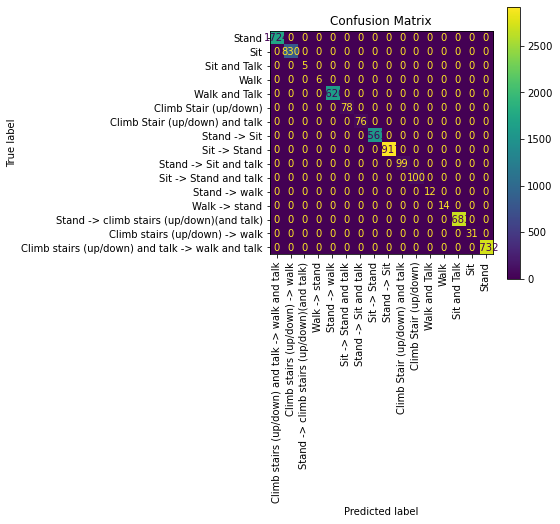

In [160]:
TO_211(feature_data, new_target, activities, 1)

### 3.1.1. TT 70-30

,Metrics
Recall,0.547964
Precision,0.543030
F1-score,0.545050


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,193,65,0,0,0,1,0,0,3,1,0,0,2,140,0,121
Sit,60,36,0,0,0,0,1,0,0,0,1,0,0,66,0,84
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
Walk,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Walk and Talk,0,0,0,0,332,0,1,136,1,1,7,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,1,3,0,8,0,4,0,0,4,0,0
Climb Stair (up/down) and talk,3,1,0,0,0,3,0,1,11,0,0,0,0,2,0,4
Stand -> Sit,0,0,0,0,115,2,2,344,4,1,7,0,0,0,0,1
Sit -> Stand,0,0,0,0,0,12,6,2,811,2,3,0,0,12,14,9
Stand -> Sit and talk,2,1,0,0,10,2,1,6,3,3,3,0,1,3,0,1


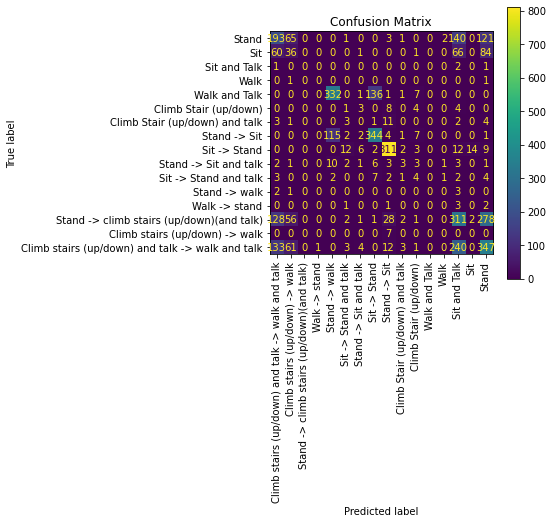

In [161]:
TT_211(feature_data, new_target, activities, 1)

### 3.1.1. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


,Metrics
Recall,0.528640
Precision,0.526277
F1-score,0.527337


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,64,15,0,0,0,0,0,0,1,0,1,45,0,55
1,21,8,0,0,0,0,0,0,0,0,0,24,0,20
2,0,0,0,0,0,0,0,0,0,0,0,2,0,1
3,0,0,0,114,0,0,38,0,0,4,0,0,0,0
4,0,1,0,0,0,1,0,4,1,0,0,3,0,1
5,0,0,0,0,0,0,0,3,1,1,0,1,0,1
6,0,0,0,34,0,0,114,2,1,1,0,1,0,0
7,1,0,0,0,3,3,1,268,1,1,0,9,5,3
8,0,0,0,4,1,0,1,0,0,0,0,0,0,1
9,0,0,0,1,0,0,5,0,2,0,0,3,0,2


------------------- Iteração 1 -------------------


,Metrics
Recall,0.566598
Precision,0.564121
F1-score,0.565130


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,61,23,0,0,0,0,1,0,1,0,1,0,0,43,0,40
Sit,22,11,1,0,0,0,1,0,0,0,1,0,0,18,0,26
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,131,0,0,42,0,0,0,0,0,0,0,0
Climb Stair (up/down),1,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0
Climb Stair (up/down) and talk,1,0,0,0,0,0,1,0,3,0,0,0,0,1,0,1
Stand -> Sit,0,0,0,0,38,0,1,103,0,2,1,0,0,0,0,0
Sit -> Stand,0,0,0,0,0,5,1,0,288,0,0,0,0,6,0,2
Stand -> Sit and talk,0,0,0,0,0,0,1,2,0,1,0,0,0,1,0,0


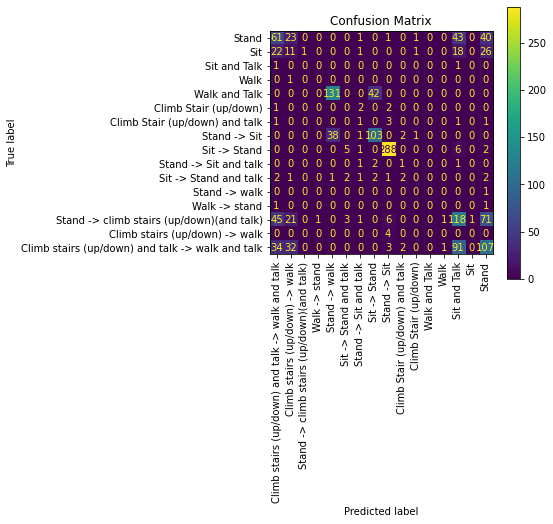

------------------- Iteração 2 -------------------


,Metrics
Recall,0.541753
Precision,0.541148
F1-score,0.538971


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,67,25,1,0,0,0,0,0,0,0,0,0,1,41,0,30
Sit,18,8,0,0,0,0,0,0,0,0,0,2,0,27,0,25
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,113,0,0,65,0,1,1,0,0,0,0,0
Climb Stair (up/down),1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
Climb Stair (up/down) and talk,3,0,0,0,0,1,0,0,5,0,0,0,0,0,0,3
Stand -> Sit,0,0,0,0,32,0,0,120,0,0,2,0,0,0,0,0
Sit -> Stand,1,0,0,0,0,5,1,0,266,0,0,0,0,3,3,2
Stand -> Sit and talk,0,0,0,0,1,0,0,1,0,3,0,0,0,4,0,0


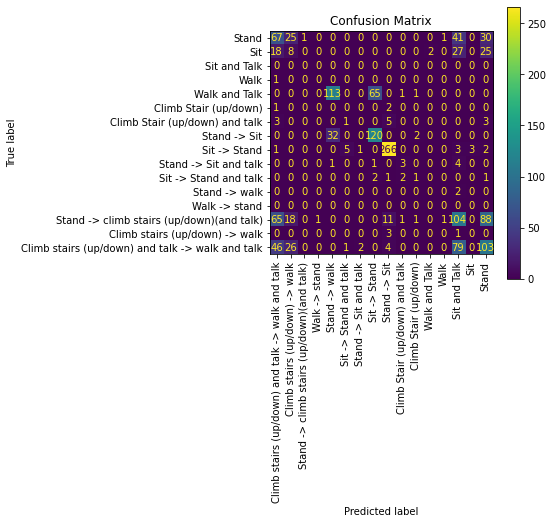

------------------- Iteração 3 -------------------


,Metrics
Recall,0.559006
Precision,0.564801
F1-score,0.561645


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,68,24,0,0,0,0,0,0,0,0,1,1,0,35,0,59
Sit,19,9,0,0,0,0,0,0,0,1,0,0,0,29,0,28
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,96,0,0,32,0,1,2,0,0,0,0,0
Climb Stair (up/down),0,1,0,0,0,0,2,0,3,1,1,0,0,0,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,2
Stand -> Sit,0,0,0,0,28,0,0,136,1,0,4,0,0,0,0,0
Sit -> Stand,1,0,0,0,0,4,5,0,278,0,0,0,0,2,7,3
Stand -> Sit and talk,1,1,0,0,0,1,1,1,1,1,1,0,0,1,0,0


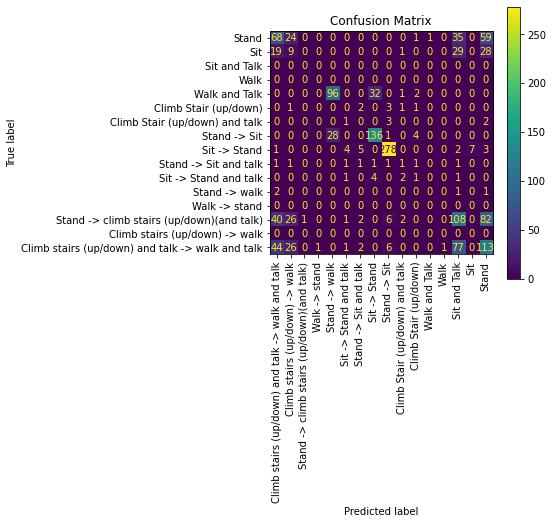

------------------- Iteração 4 -------------------


,Metrics
Recall,0.535542
Precision,0.535985
F1-score,0.534898


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,48,21,1,0,0,1,0,0,0,0,2,0,0,44,0,44
Sit,25,12,0,0,0,0,0,0,1,1,0,0,1,22,0,21
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,111,0,0,46,0,2,1,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,2
Climb Stair (up/down) and talk,0,0,0,0,0,0,1,0,2,1,1,0,0,1,1,1
Stand -> Sit,0,0,0,0,32,0,1,117,2,0,2,0,0,0,0,0
Sit -> Stand,0,0,0,0,0,2,3,1,263,0,1,0,0,3,0,9
Stand -> Sit and talk,0,0,0,0,1,0,1,4,0,1,1,0,0,1,0,2


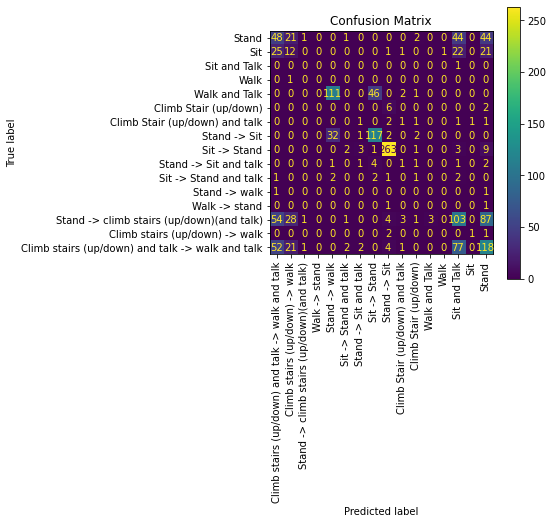

------------------- Iteração 5 -------------------


,Metrics
Recall,0.546584
Precision,0.537671
F1-score,0.540554


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,60,20,1,0,1,1,0,0,0,1,1,50,0,42
1,25,13,0,0,0,0,0,1,0,0,0,26,0,25
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,122,0,0,51,0,1,1,0,0,0,0
4,0,0,0,1,1,1,0,3,0,0,0,0,0,0
5,0,1,0,0,1,0,1,4,0,0,0,2,0,1
6,0,0,0,25,1,0,121,0,0,0,0,1,0,0
7,0,0,0,0,3,2,0,259,3,0,0,3,1,1
8,0,0,0,4,0,0,1,0,2,0,0,1,0,0
9,1,0,0,3,0,0,6,0,0,1,0,1,0,1


------------------- Iteração 6 -------------------


,Metrics
Recall,0.544513
Precision,0.548069
F1-score,0.545876


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,46,28,0,0,0,1,0,0,2,0,1,1,53,0,43
1,27,13,1,0,1,0,0,0,1,0,0,0,16,0,25
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,133,0,0,46,1,0,1,0,0,0,0,0
4,2,0,0,0,1,0,0,2,0,0,0,1,2,0,0
5,1,1,0,0,2,0,0,2,0,0,0,0,0,1,0
6,0,0,0,39,0,2,103,1,3,2,0,0,0,0,2
7,2,0,0,0,1,1,0,275,0,0,0,0,7,5,2
8,0,0,0,1,0,0,1,0,1,1,0,0,2,0,1
9,2,0,0,1,0,0,3,1,1,3,0,0,1,0,0


------------------- Iteração 7 -------------------


,Metrics
Recall,0.540373
Precision,0.533560
F1-score,0.536647


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,65,23,0,1,1,0,0,2,0,0,0,48,0,40
1,21,10,0,0,1,0,0,0,0,0,0,25,0,29
2,0,0,123,0,0,46,0,2,1,0,0,0,0,0
3,0,0,0,0,0,0,9,0,0,0,0,0,0,1
4,1,0,0,0,0,0,1,1,0,0,0,3,0,1
5,0,0,54,1,0,92,0,0,2,0,0,0,0,0
6,0,1,0,2,4,1,300,0,1,0,0,2,2,4
7,1,1,2,0,0,3,0,0,2,0,0,1,0,1
8,0,1,2,0,0,2,2,1,0,0,1,2,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0


------------------- Iteração 8 -------------------


,Metrics
Recall,0.539365
Precision,0.532902
F1-score,0.535851


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,57,16,1,1,0,0,0,0,0,0,0,0,1,54,0,47
Sit,23,12,0,0,0,0,0,0,0,0,0,0,0,19,0,18
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,103,0,0,41,0,1,1,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,3,1,0,4,0,2,0,0,0,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,1,0,0,4,0,0,0,0,2,0,1
Stand -> Sit,0,0,0,0,31,0,0,142,1,1,2,0,0,0,0,0
Sit -> Stand,3,0,0,0,1,2,3,0,251,0,0,0,0,5,2,5
Stand -> Sit and talk,0,2,0,0,3,0,0,3,4,0,1,0,0,1,0,1


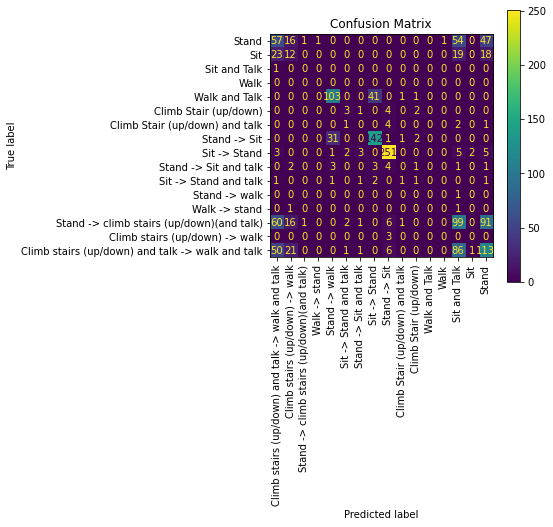

------------------- Iteração 9 -------------------


,Metrics
Recall,0.546961
Precision,0.547530
F1-score,0.544845


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,54,14,0,0,1,0,0,2,0,2,0,44,0,33
1,19,15,0,0,0,0,0,0,0,0,0,32,0,30
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,110,0,0,35,0,1,0,0,0,0,0
4,0,1,0,0,0,1,0,3,0,1,0,2,0,1
5,0,0,0,0,0,0,0,3,1,0,0,0,0,0
6,0,0,0,40,0,0,116,1,0,1,0,2,0,0
7,0,1,0,0,3,2,2,282,0,0,0,5,2,6
8,1,1,0,0,0,1,3,1,3,5,0,1,0,1
9,0,0,0,1,0,0,1,0,0,1,0,0,0,1


In [162]:
CV_211(feature_data, new_target, 10, activities, 1)

### 3.1.2. Train-only

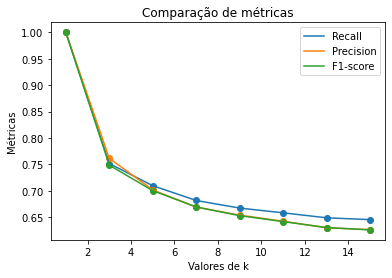

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,1724,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit,0,830,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit and Talk,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,1620,0,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,78,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,0,76,0,0,0,0,0,0,0,0,0
Stand -> Sit,0,0,0,0,0,0,0,1561,0,0,0,0,0,0,0,0
Sit -> Stand,0,0,0,0,0,0,0,0,2917,0,0,0,0,0,0,0
Stand -> Sit and talk,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,0


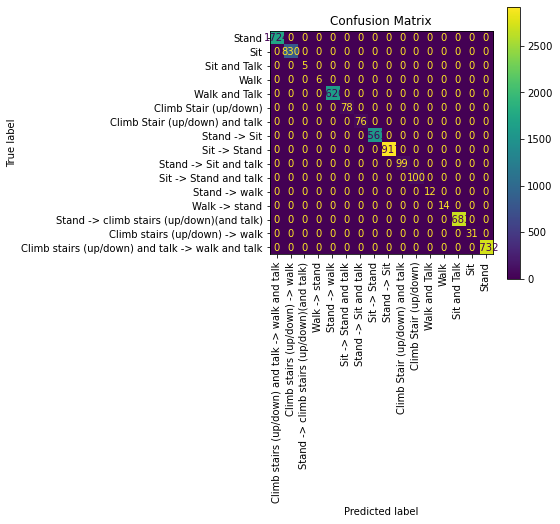

In [163]:
TO_gama(feature_data, new_target, activities)

### 3.1.2. TVT 40-30-30

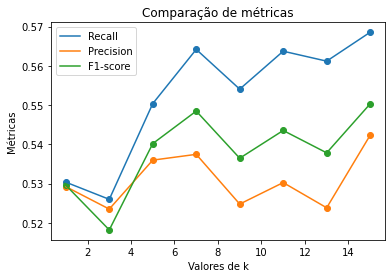

Best K: 15


,Metrics
Recall,0.588912
Precision,0.558058
F1-score,0.568962


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,235,17,0,0,0,0,0,0,0,0,0,0,0,116,0,118
Sit,85,8,0,0,0,0,0,0,0,1,0,0,0,74,0,60
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Walk and Talk,0,0,0,0,325,0,0,169,5,0,1,0,0,0,0,0
Climb Stair (up/down),1,0,0,0,0,0,1,0,12,0,3,0,0,4,0,1
Climb Stair (up/down) and talk,2,0,0,0,0,0,0,0,11,2,1,0,0,5,0,2
Stand -> Sit,0,0,0,0,121,0,0,347,12,0,0,0,0,0,0,1
Sit -> Stand,0,0,0,0,3,0,0,0,866,0,0,0,0,12,0,2
Stand -> Sit and talk,3,3,0,0,9,0,0,6,3,1,0,0,0,6,0,2


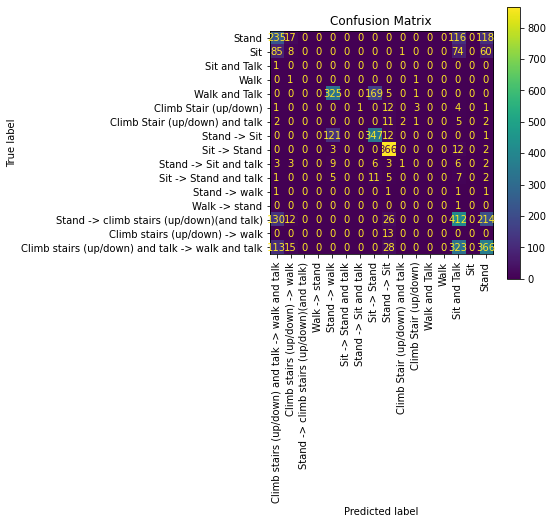

In [164]:
TVT_gama(feature_data, new_target, activities)

### 3.1.2. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


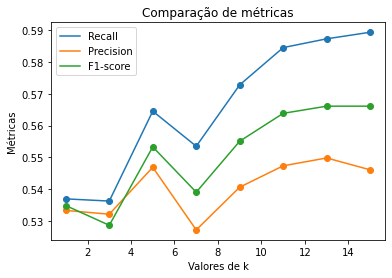

Best K: 13


,Metrics
Recall,0.587302
Precision,0.549798
F1-score,0.566100


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,93,4,0,0,0,0,0,0,0,0,0,0,0,44,0,49
Sit,37,1,0,0,0,0,0,0,0,0,0,0,0,22,0,22
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,106,0,0,52,0,1,0,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,0,0,0,4,0,0,0,0,2,0,0
Climb Stair (up/down) and talk,1,0,0,0,0,0,0,0,3,0,0,0,0,2,0,0
Stand -> Sit,0,0,0,0,38,0,1,105,0,1,0,0,0,0,0,0
Sit -> Stand,2,0,0,0,1,0,0,0,278,0,0,0,0,0,0,1
Stand -> Sit and talk,0,1,0,0,1,1,0,1,4,0,0,0,0,2,0,0


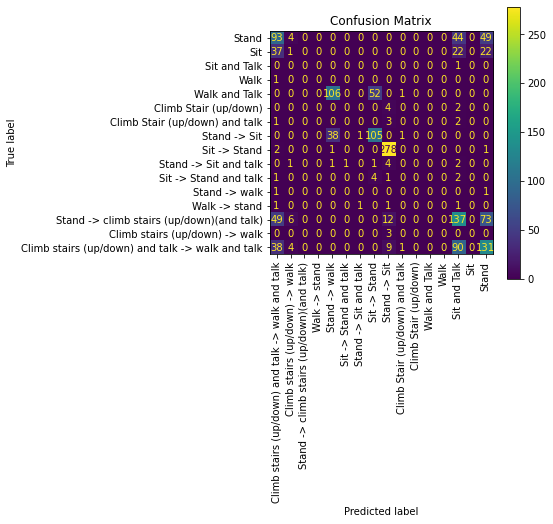

------------------- Iteração 1 -------------------


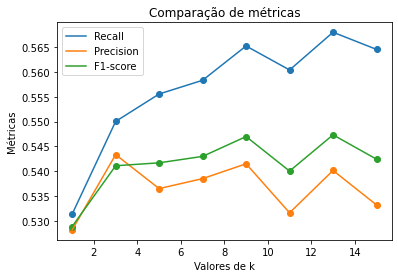

Best K: 13


,Metrics
Recall,0.567978
Precision,0.540174
F1-score,0.547339


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,64,6,0,0,0,0,0,0,0,0,0,0,42,0,30
1,29,6,0,0,0,0,0,0,0,0,0,0,38,0,29
2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,95,0,0,64,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,5,0,0,0,0,3,0,0
5,0,0,0,0,0,0,0,4,2,0,0,0,1,0,0
6,0,0,0,43,0,0,128,3,0,0,0,0,1,0,0
7,2,0,0,0,1,0,0,277,0,0,0,0,2,0,0
8,0,0,0,0,0,0,7,0,1,2,0,0,1,0,1
9,1,0,0,1,0,0,3,1,0,0,0,0,2,0,1


------------------- Iteração 2 -------------------


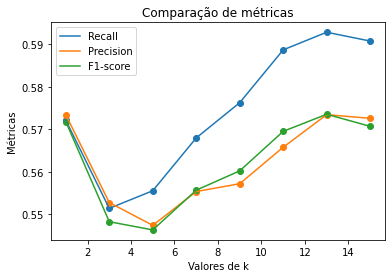

Best K: 13


,Metrics
Recall,0.592823
Precision,0.573445
F1-score,0.573539


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,68,3,0,0,0,0,0,0,0,0,0,0,39,0,46
1,29,4,0,0,0,0,0,0,0,0,0,0,24,0,30
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,109,0,0,51,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,5,0,1,0,0,2,0,0
6,0,0,0,47,0,0,128,4,0,0,0,0,0,0,0
7,0,0,0,1,0,0,0,273,0,0,0,0,5,0,1
8,1,0,0,1,0,0,2,0,1,0,0,0,4,0,0
9,0,1,0,0,0,0,3,0,0,0,0,0,1,0,1


------------------- Iteração 3 -------------------


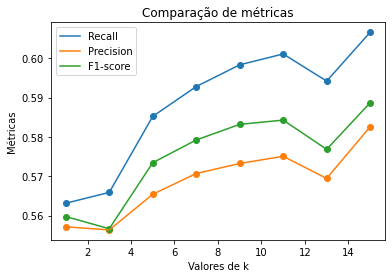

Best K: 15


,Metrics
Recall,0.606625
Precision,0.582601
F1-score,0.588701


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,84,8,0,0,0,0,0,0,1,0,0,0,42,0,43
1,29,4,0,0,0,0,0,0,0,0,0,0,29,0,17
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,117,0,0,52,1,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,4,0,0,0,0,1,0,1
5,1,0,0,0,0,0,0,4,1,0,0,0,1,0,1
6,0,0,0,32,0,0,115,1,1,0,0,0,0,0,0
7,0,0,0,0,0,0,0,298,0,0,0,0,3,0,2
8,1,0,0,3,0,0,4,0,1,0,0,0,0,0,1
9,1,0,0,0,1,0,2,1,0,1,0,0,1,0,0


------------------- Iteração 4 -------------------


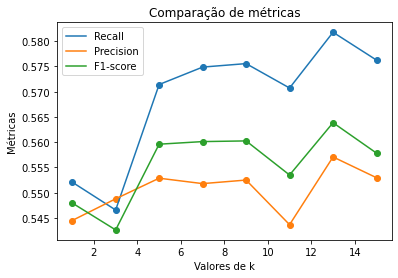

Best K: 13


,Metrics
Recall,0.581781
Precision,0.557089
F1-score,0.563867


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63,9,0,0,0,0,0,0,0,0,0,0,43,36
1,29,6,0,0,0,0,0,0,1,0,0,0,27,24
2,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,0,0,0,109,0,0,45,4,0,0,0,0,0,0
4,1,0,0,0,1,0,0,8,0,0,0,0,2,0
5,1,0,0,0,0,0,0,3,0,0,0,0,2,2
6,0,0,0,45,0,0,114,3,1,0,0,0,1,0
7,1,0,0,0,1,0,1,289,0,0,0,0,2,0
8,0,1,0,1,0,0,4,0,0,0,0,0,1,1
9,0,1,0,2,0,0,3,3,0,0,0,0,4,0


------------------- Iteração 5 -------------------


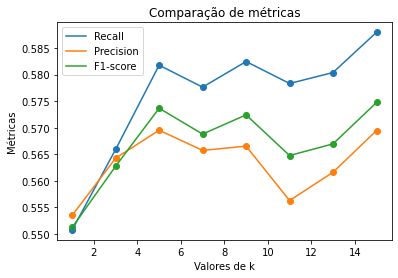

Best K: 15


,Metrics
Recall,0.587992
Precision,0.569458
F1-score,0.574747


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,79,4,0,0,0,0,0,0,0,0,0,55,0,58
1,30,3,0,0,0,0,0,0,0,0,0,18,0,20
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,107,0,0,58,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,3,0,0,0,0,0,1
6,0,0,0,32,0,0,117,3,0,0,0,0,0,0
7,2,0,0,2,1,1,0,292,0,0,0,6,0,0
8,1,0,0,1,1,0,1,1,2,0,0,1,0,3
9,2,2,0,3,0,0,1,1,0,0,0,1,0,1


------------------- Iteração 6 -------------------


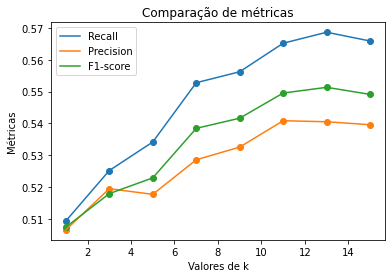

Best K: 13


,Metrics
Recall,0.568668
Precision,0.540526
F1-score,0.551352


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,83,8,0,0,0,0,0,0,0,0,0,0,52,0,43
1,26,5,0,0,0,0,0,1,0,0,0,0,21,0,25
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,97,0,0,46,1,0,2,0,0,0,0,0
4,0,0,0,0,0,0,0,4,0,1,0,0,2,0,0
5,1,0,0,0,0,0,0,8,0,0,0,0,0,0,0
6,0,0,0,36,0,0,109,3,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,288,0,0,0,0,3,0,2
8,0,1,0,2,1,1,3,1,0,1,0,0,0,0,0
9,0,0,0,0,0,0,3,3,2,0,0,0,0,0,1


------------------- Iteração 7 -------------------


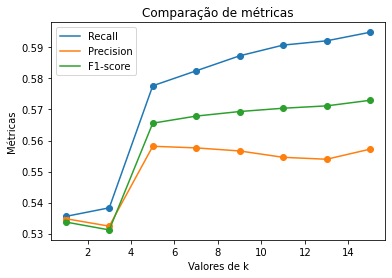

Best K: 15


,Metrics
Recall,0.594893
Precision,0.557225
F1-score,0.572961


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,77,8,0,0,0,0,1,0,0,0,51,0,38
1,30,0,0,0,0,0,0,0,0,0,22,0,27
2,1,0,120,0,0,41,1,0,0,0,0,0,0
3,0,0,0,0,0,0,4,1,0,0,1,0,0
4,0,0,0,0,0,0,3,0,0,0,5,0,0
5,0,0,28,0,0,110,6,0,0,0,0,0,0
6,0,0,3,1,0,1,299,0,0,0,2,0,0
7,0,0,3,1,0,2,1,1,0,0,1,0,4
8,1,1,1,0,0,8,3,0,0,0,3,0,1
9,0,0,0,0,0,0,0,0,0,0,1,0,1


------------------- Iteração 8 -------------------


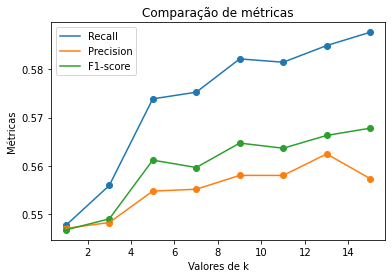

Best K: 15


,Metrics
Recall,0.587707
Precision,0.557359
F1-score,0.567817


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,77,7,0,0,0,0,0,0,0,0,57,0,31
1,35,3,0,0,0,0,0,0,1,0,22,0,30
2,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,120,0,0,52,0,0,0,0,0,0
4,0,0,0,0,0,0,0,4,1,0,1,0,1
5,0,0,0,0,0,0,1,4,2,0,1,0,1
6,0,0,0,36,0,0,106,3,0,0,0,0,0
7,1,0,0,1,0,0,2,311,1,0,1,0,1
8,1,0,0,1,0,0,0,2,1,1,1,0,0
9,1,0,0,0,0,0,6,0,1,0,0,0,0


------------------- Iteração 9 -------------------


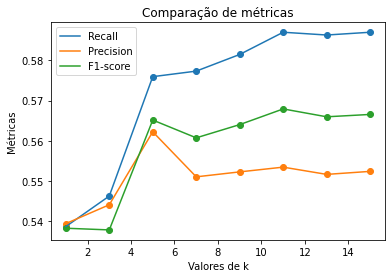

Best K: 11


,Metrics
Recall,0.587017
Precision,0.553463
F1-score,0.567942


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,86,10,0,0,0,0,0,0,0,0,40,0,42
1,41,2,0,0,0,0,0,0,0,0,17,0,14
2,0,0,126,0,0,40,0,0,0,0,0,0,0
3,0,0,0,0,0,1,8,0,0,0,2,0,1
4,1,1,0,0,0,0,6,0,0,0,1,0,0
5,0,0,33,0,0,126,0,0,0,0,0,0,1
6,0,0,0,1,0,1,248,0,0,0,4,0,1
7,0,0,3,1,0,2,1,0,1,0,1,0,0
8,0,0,0,0,0,4,3,0,0,0,3,0,1
9,0,0,0,0,0,0,0,0,0,0,0,0,1


In [165]:
CV_gama(feature_data, new_target, activities)

### 3.2. ReliefF

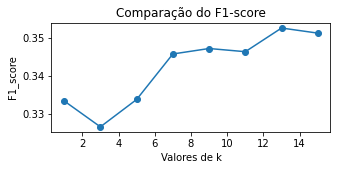

Nr of features: 1
Best K: 13
F1_score: 0.34504108921612797
--------------------------------------------------


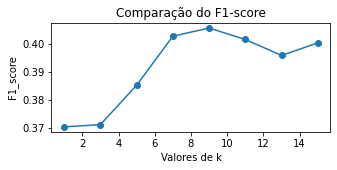

Nr of features: 2
Best K: 9
F1_score: 0.3932205879346488
--------------------------------------------------


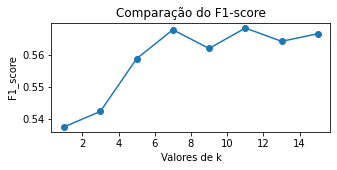

Nr of features: 3
Best K: 11
F1_score: 0.5627063666485017
--------------------------------------------------


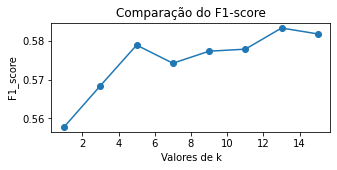

Nr of features: 4
Best K: 13
F1_score: 0.5770945110765697
--------------------------------------------------


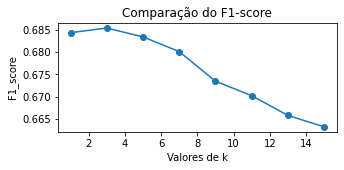

Nr of features: 5
Best K: 3
F1_score: 0.6803464608112697
--------------------------------------------------


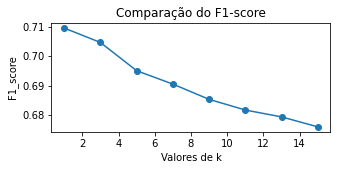

Nr of features: 6
Best K: 1
F1_score: 0.708876479013256
--------------------------------------------------


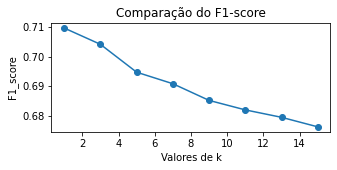

Nr of features: 7
Best K: 1
F1_score: 0.7084030672140932
--------------------------------------------------


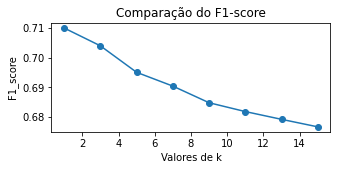

Nr of features: 8
Best K: 1
F1_score: 0.7087197734615804
--------------------------------------------------


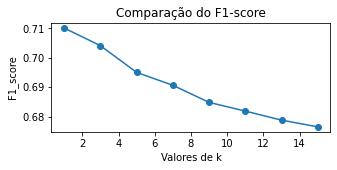

Nr of features: 9
Best K: 1
F1_score: 0.7085656984781818
--------------------------------------------------


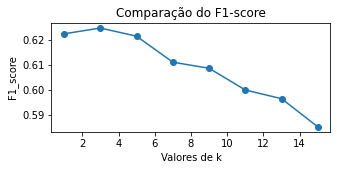

Nr of features: 10
Best K: 3
F1_score: 0.6293700496963203
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.333511,0.326694,0.333898,0.345870,0.347308,0.346470,0.352699,0.351356
Nº of features: 2,0.370432,0.371225,0.385324,0.402836,0.405757,0.401656,0.395964,0.400438
Nº of features: 3,0.537459,0.542281,0.558697,0.567725,0.561885,0.568258,0.564119,0.566463
Nº of features: 4,0.557822,0.568502,0.579033,0.574330,0.577451,0.577975,0.583460,0.581931
Nº of features: 5,0.684377,0.685426,0.683429,0.680118,0.673460,0.670210,0.665768,0.663198
Nº of features: 6,0.709495,0.704618,0.695075,0.690555,0.685402,0.681792,0.679475,0.676110
Nº of features: 7,0.709759,0.704242,0.694803,0.690899,0.685251,0.682036,0.679522,0.676294
Nº of features: 8,0.709904,0.703933,0.695052,0.690428,0.684852,0.681891,0.679288,0.676768
Nº of features: 9,0.710135,0.704135,0.695052,0.690666,0.684852,0.681891,0.678820,0.676533
Nº of features: 10,0.622478,0.624778,0.621504,0.611165,0.608753,0.600091,0.596632,0.585415


In [166]:
newActivity_elbow, df3, str_print = repeatTVT(feature_data,new_target, reliefF(feature_data, new_target), 10)

### 3.2. Elbow Graph

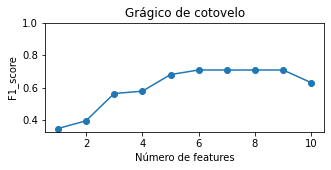

In [167]:
elbowGraph(newActivity_elbow, 11)

### 3.3. Validation set results

In [168]:
display(df3)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.333511,0.326694,0.333898,0.345870,0.347308,0.346470,0.352699,0.351356
Nº of features: 2,0.370432,0.371225,0.385324,0.402836,0.405757,0.401656,0.395964,0.400438
Nº of features: 3,0.537459,0.542281,0.558697,0.567725,0.561885,0.568258,0.564119,0.566463
Nº of features: 4,0.557822,0.568502,0.579033,0.574330,0.577451,0.577975,0.583460,0.581931
Nº of features: 5,0.684377,0.685426,0.683429,0.680118,0.673460,0.670210,0.665768,0.663198
Nº of features: 6,0.709495,0.704618,0.695075,0.690555,0.685402,0.681792,0.679475,0.676110
Nº of features: 7,0.709759,0.704242,0.694803,0.690899,0.685251,0.682036,0.679522,0.676294
Nº of features: 8,0.709904,0.703933,0.695052,0.690428,0.684852,0.681891,0.679288,0.676768
Nº of features: 9,0.710135,0.704135,0.695052,0.690666,0.684852,0.681891,0.678820,0.676533
Nº of features: 10,0.622478,0.624778,0.621504,0.611165,0.608753,0.600091,0.596632,0.585415


### 3.4. Test set results

In [169]:
print(str_print)

Nr of features: 1
Best K: 13
F1_score: 0.34504108921612797
--------------------------------------------------
Nr of features: 2
Best K: 9
F1_score: 0.3932205879346488
--------------------------------------------------
Nr of features: 3
Best K: 11
F1_score: 0.5627063666485017
--------------------------------------------------
Nr of features: 4
Best K: 13
F1_score: 0.5770945110765697
--------------------------------------------------
Nr of features: 5
Best K: 3
F1_score: 0.6803464608112697
--------------------------------------------------
Nr of features: 6
Best K: 1
F1_score: 0.708876479013256
--------------------------------------------------
Nr of features: 7
Best K: 1
F1_score: 0.7084030672140932
--------------------------------------------------
Nr of features: 8
Best K: 1
F1_score: 0.7087197734615804
--------------------------------------------------
Nr of features: 9
Best K: 1
F1_score: 0.7085656984781818
--------------------------------------------------
Nr of features: 10
Best K

### 4. Neural net

In [170]:
from sklearn.neural_network import MLPClassifier

targetNum = new_target

dataTVT = train_validation_test(feature_data, new_target, 0.4, 0.3)

def plot_f1(metr, neur_evol):
    plt.figure()

    plt.plot(neur_evol, metr, label="f1")
    plt.scatter(neur_evol, metr)
    
    plt.title("Evolução do f1-score")
    plt.xlabel("Número de neurónios")
    plt.ylabel("f1-score")
    plt.show()

### 4.1. Fixed learning speed

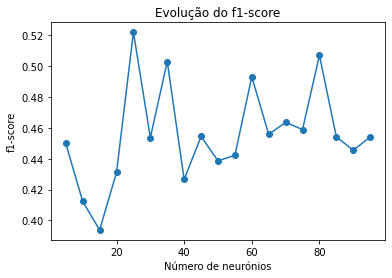

Best neurons number: 25


,Metrics
Recall,0.575569
Precision,0.528412
F1-score,0.505110


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,189,0,0,0,0,0,0,0,0,0,0,0,0,3,0,284
Sit,70,0,0,0,0,0,0,0,0,0,0,0,0,3,0,199
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
Walk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
Walk and Talk,0,0,0,0,435,0,0,55,0,0,0,0,0,0,0,0
Climb Stair (up/down),3,0,0,0,0,0,0,1,11,0,0,0,0,0,0,4
Climb Stair (up/down) and talk,3,0,0,0,0,0,0,2,8,0,0,0,0,1,0,8
Stand -> Sit,0,0,0,0,153,0,0,358,1,0,0,0,0,0,0,2
Sit -> Stand,3,0,0,0,0,0,0,6,832,0,0,0,0,2,0,25
Stand -> Sit and talk,2,0,0,0,6,0,0,14,0,0,0,0,0,0,0,14


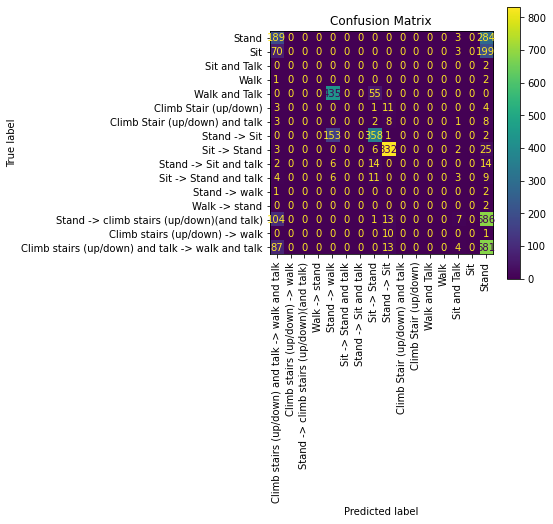

In [171]:
from sklearn.preprocessing import StandardScaler  

def mlp_4(type_speed):
    nns = []
    metrF1 = []

    neur_evol = np.arange(5, 100, 5)

    for i in neur_evol:
        if type_speed == 'fixed':
            clf = MLPClassifier(activation='logistic', solver='sgd', learning_rate_init=0.1, hidden_layer_sizes=i, max_iter=2000)
        elif type_speed == 'variable':
            clf = MLPClassifier(activation='logistic', learning_rate='invscaling', solver='sgd', learning_rate_init=0.1, hidden_layer_sizes=i, max_iter=2000)
        else:
             clf = MLPClassifier(activation='logistic', hidden_layer_sizes=i, solver='sgd', learning_rate_init=0.1, momentum=0.5, max_iter=2000)
        
        nns.append(clf.fit(dataTVT["TRAIN"][0], dataTVT["TRAIN"][1]))

        pred = clf.predict(dataTVT["VALIDATION"][0])

        true = dataTVT['VALIDATION'][1]
        
        cm, rs, ps, f1 = metrics(true, pred)

        metrF1.append(f1)

    plot_f1(metrF1, neur_evol)

    print("Best neurons number: " + str(neur_evol[np.argmax(metrF1)]))

    best_nns = nns[np.argmax(metrF1)]
    pred = best_nns.predict(dataTVT["TEST"][0])
    true = dataTVT['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    mais_bonito(cm, rs, ps, f1, activities)

mlp_4('fixed')


### 4.2. Variable learning speed

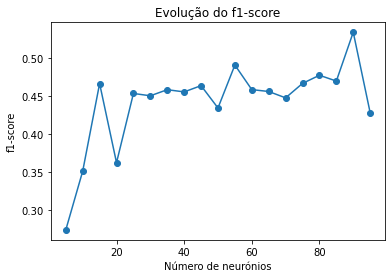

Best neurons number: 90


,Metrics
Recall,0.547044
Precision,0.511164
F1-score,0.520580


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,256,0,0,0,0,0,0,0,0,0,0,0,0,44,0,176
Sit,117,0,0,0,0,0,0,0,0,0,0,0,0,41,0,114
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Walk,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
Walk and Talk,0,0,0,0,358,0,0,130,0,0,0,0,0,2,0,0
Climb Stair (up/down),3,0,0,0,0,0,0,0,12,0,0,0,0,3,0,1
Climb Stair (up/down) and talk,2,0,0,0,0,0,0,0,9,0,0,0,0,8,0,3
Stand -> Sit,1,0,0,0,228,0,0,278,2,0,0,0,0,4,0,1
Sit -> Stand,3,0,0,0,0,0,0,1,833,0,0,0,0,27,0,4
Stand -> Sit and talk,2,0,0,0,6,0,0,10,0,0,0,0,0,12,0,6


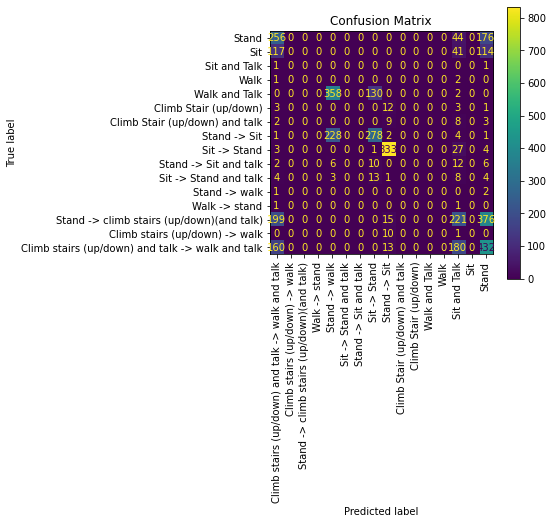

In [172]:
mlp_4('variable')

### 4.3. Momentum coeficient

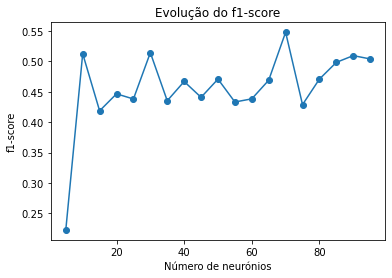

Best neurons number: 70


,Metrics
Recall,0.567978
Precision,0.532134
F1-score,0.534760


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,127,0,0,0,0,0,0,0,0,0,0,0,0,188,0,161
Sit,42,0,0,0,0,0,0,0,0,0,0,0,0,117,0,113
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2
Walk and Talk,0,0,0,0,450,0,0,38,1,1,0,0,0,0,0,0
Climb Stair (up/down),3,0,0,0,0,0,0,0,13,0,0,0,0,2,0,1
Climb Stair (up/down) and talk,4,0,0,0,0,0,0,0,10,0,0,0,0,3,0,5
Stand -> Sit,1,0,0,0,216,0,0,292,3,0,0,0,0,1,0,1
Sit -> Stand,5,0,0,0,0,0,0,0,842,0,0,0,0,2,0,19
Stand -> Sit and talk,2,0,0,0,5,0,0,11,3,0,0,0,0,9,0,6


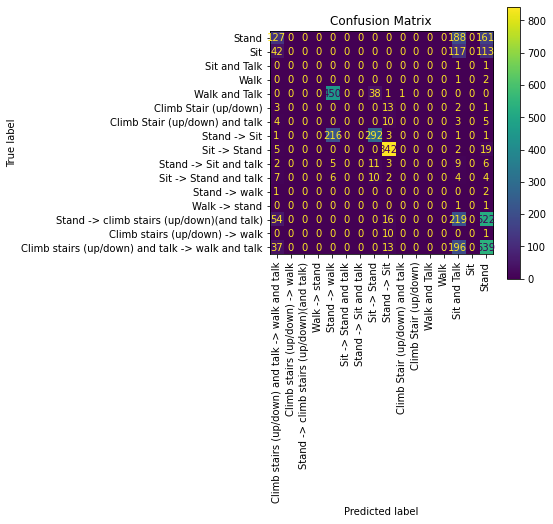

In [173]:
mlp_4('momentum')

### 5. Neural net from scratch

In [203]:
class MLP():
    def __init__(self, x, y, hidden_layers, num_outputs, printar = False):
        """
            num_inputs (int): Number of inputs
            hidden_layers (list): A list of ints for the hidden layers
            num_outputs (int): Number of outputs
        """
        self.x = x
        self.y = y
        self.printar = printar
        self.num_inputs = self.x.shape[1]
        self.hidden_layers = hidden_layers
        self.num_outputs = num_outputs

        layers = [self.x.shape[1]] + hidden_layers + [num_outputs] # create a generic representation of the layers

        # create random connection weights for the layers
        weights = []
        for i in range(len(layers) - 1):
            weights.append(np.random.rand(layers[i], layers[i + 1]))
        self.weights = weights

        # save derivatives per layer
        derivatives = []
        for i in range(len(layers) - 1):
            derivatives.append(np.zeros((layers[i], layers[i + 1])))
        self.derivatives = derivatives

        # save activations per layer
        activations = []
        for i in range(len(layers)):
            activations.append(np.zeros(layers[i]))

        self.activations = activations


    def _feedforward(self, inputs):
        """
        Args:
            inputs (ndarray): Input signals
        Returns:
            activations (ndarray): Output values
        """

        activations = inputs # the input layer activation is just the input itself

        self.activations[0] = activations # save the activations for backpropogation

        # iterate through the network layers
        for i, w in enumerate(self.weights):
            net_inputs = np.dot(activations, w) # calculate matrix multiplication between previous activation and weight matrix
            activations = self._sigmoid(net_inputs) # apply sigmoid activation function
            self.activations[i + 1] = activations # save the activations for backpropogation

        return activations # return output layer activation


    def _backprop(self, error):
        """
        Args:
            error (ndarray): The error to backprop.
        Returns:
            error (ndarray): The final error of the input
        """

        # iterate backwards through the network layers
        for i in reversed(range(len(self.derivatives))):

            activations = self.activations[i+1] # get activation for previous layer

            delta = error * self._sigmoid_derivative(activations) # apply sigmoid derivative function
            delta_re = delta.reshape(delta.shape[0], -1).T # reshape delta as to have it as a 2d array
            current_activations = self.activations[i] # get activations for current layer

            current_activations = current_activations.reshape(current_activations.shape[0],-1) # reshape activations as to have them as a 2d column matrix

            self.derivatives[i] = np.dot(current_activations, delta_re) # save derivative after applying matrix multiplication

            error = np.dot(delta, self.weights[i].T) # backpropogate the next error


    def fit(self, epochs, learning_rate):
        """
        Args:
            inputs (ndarray): X
            targets (ndarray): Y
            epochs (int): Num. epochs we want to train the network for
            learning_rate (float): Step to apply to gradient descent
        """
        # now enter the training loop
        for i in range(epochs):
            sum_errors = 0

            # iterate through all the training data
            for input, targetY in zip(self.x, self.y):
                
                output = self._feedforward(input) # activate the network!
                error = targetY - output

                self._backprop(error)

                self.gradient_descent(learning_rate) # now perform gradient descent on the derivatives -> this will update the weights
                
                sum_errors += np.average((targetY - output) ** 2) # keep track of the MSE for reporting later

            if self.printar: # Epoch complete, report the training error
                print("Error: {} at epoch {}".format(sum_errors / len(self.x), i+1))

    def predict(self,test):
        if self.num_outputs == 1: 
            return np.array([self._feedforward(t) for t in test])
        else:
            output = []
            for t in test:
                pred = list(self._feedforward(t))
                # maximo dos nos do output
                output.append(pred.index(max(pred)))
            return np.array(output)

    def gradient_descent(self, learningRate=1):
        """
        Args:
            learningRate (float): How fast to learn.
        """
        # update the weights by stepping down the gradient
        for i in range(len(self.weights)):
            weights = self.weights[i]
            derivatives = self.derivatives[i]
            weights += derivatives * learningRate


    def _sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))


    def _sigmoid_derivative(self, x):
        return x * (1.0 - x)

In [207]:
def mlp_5():
    nns = []
    metrF1 = []

    neur_evol = np.arange(5, 100, 5)

    
    for i in neur_evol:
        clf = MLP(dataTVT["TRAIN"][0], dataTVT["TRAIN"][1], hidden_layers=[i], num_outputs=16)

        nns.append(clf.fit(epochs = 500, learning_rate=0.1))

        pred = clf.predict(dataTVT["VALIDATION"][0])

        true = dataTVT['VALIDATION'][1]
        
        cm, rs, ps, f1 = metrics(true, pred)

        metrF1.append(f1)

    plot_f1(metrF1, neur_evol)

    print("Best neurons number: " + str(neur_evol[np.argmax(metrF1)]))

    best_nns = nns[np.argmax(metrF1)]
    pred = best_nns.predict(dataTVT["TEST"][0])
    true = dataTVT['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    mais_bonito(cm, rs, ps, f1, activities)


dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Stand"] = 0
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Sit"] = 1
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Sit and Talk"] = 2
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Walk"] = 3
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Walk and Talk"] = 4
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Climb Stair (up/down)"] = 5
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Climb Stair (up/down) and talk"] = 6
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Stand -> Sit"] = 7
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Sit -> Stand"] = 8
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Stand -> Sit and talk"] = 9
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Sit -> Stand and talk"] = 10
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Stand -> walk"] = 11
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Walk -> stand"] = 12
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Stand -> climb stairs (up/down)(and talk)"] = 13
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Climb stairs (up/down) -> walk"] = 14
dataTVT["TRAIN"][1][dataTVT["TRAIN"][1] == "Climb stairs (up/down) and talk -> walk and talk"] = 15

dataTVT["TEST"][1][dataTVT["TEST"][1] == "Stand"] = 0
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Sit"] = 1
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Sit and Talk"] = 2
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Walk"] = 3
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Walk and Talk"] = 4
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Climb Stair (up/down)"] = 5
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Climb Stair (up/down) and talk"] = 6
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Stand -> Sit"] = 7
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Sit -> Stand"] = 8
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Stand -> Sit and talk"] = 9
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Sit -> Stand and talk"] = 10
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Stand -> walk"] = 11
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Walk -> stand"] = 12
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Stand -> climb stairs (up/down)(and talk)"] = 13
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Climb stairs (up/down) -> walk"] = 14
dataTVT["TEST"][1][dataTVT["TEST"][1] == "Climb stairs (up/down) and talk -> walk and talk"] = 15

dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Stand"] = 0
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Sit"] = 1
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Sit and Talk"] = 2
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Walk"] = 3
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Walk and Talk"] = 4
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Climb Stair (up/down)"] = 5
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Climb Stair (up/down) and talk"] = 6
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Stand -> Sit"] = 7
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Sit -> Stand"] = 8
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Stand -> Sit and talk"] = 9
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Sit -> Stand and talk"] = 10
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Stand -> walk"] = 11
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Walk -> stand"] = 12
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Stand -> climb stairs (up/down)(and talk)"] = 13
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Climb stairs (up/down) -> walk"] = 14
dataTVT["VALIDATION"][1][dataTVT["VALIDATION"][1] == "Climb stairs (up/down) and talk -> walk and talk"] = 15

mlp_5()


ValueError: Classification metrics can't handle a mix of unknown and binary targets